In [1]:
import os
import numpy as np
import xarray as xr
import subprocess
from matplotlib import pyplot as plt

In [58]:
dir_t2 = '/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/'
var_1d = ['TREFMXAV', 'TREFMNAV']
n_var = len(var_1d)

## SSP370
year_s = 2015
year_e = 2095

## BHIST
year_s = 1980
year_e = 2010

#### Creating weights
I use the 2m air_temperature LENS2 dataset to calculate the area-weighted temperature over its domain. This dataset has a regular latitude/ longitude grid, thus the grid cell area decreases towards the pole, using the cosine of the latitude as proxy for the grid cell area. <br>
https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html#Weighted-mean

In [59]:
flnm = '/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BHISTcmip6.f09_g17.LE2-1281.010.clm2.h0.TREFMXAV.195001-195912.nc'
with xr.open_dataset(flnm) as ds:
    air = ds[var_1d[0]]
    ## For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
    weights = np.cos(np.deg2rad(air.lat))
    weights.name = "weights"
    
    # weighted mean
    air_weighted = air.weighted(weights)
       

In [60]:
cmd_ls = 'ls -1 ' + dir_t2 + var_1d[0] + '/b.e21.BHIST*.' + 'h0.TREFMXAV.195001*.nc '

# store os.system() output in a variable 
flnm_str = os.popen(cmd_ls).read()

# convert string to list and through out last item which is empty
flnm_li = list(flnm_str.split("\n"))[:-1]
n_mem = len(flnm_li)
print(n_mem, 'members') 

100 members


In [66]:
## the last one is 209501-210012 6 years
n_month = (year_e - year_s)*12 + 60
print(n_month, ' months in dataset')

n_year = int(n_month/12)

t2_3d = np.zeros((n_var, n_mem, n_month))

n_month_dec = 120

nv = 0
for var_s in var_1d:
    for year in range(year_s, year_e+1, 10):
        # the start index of each file
        ct_st = int((year-year_s)*0.1*n_month_dec)
        if year == year_e:
            ct_e = ct_st + 60
        else:
            ct_e = ct_st + n_month_dec
            
        cmd_ls = 'ls -1 ' + dir_t2 + var_1d[nv] + '/b.e21.BHIST*' + 'h0.'+var_1d[nv]+'.' + str(year)+ '01*.nc '
        #print(cmd_ls)
        # store os.system() output in a variable 
        flnm_str = os.popen(cmd_ls).read()

        # convert string to list and through out last item which is empty
        flnm_li = list(flnm_str.split("\n"))[:-1]
        n_mem_t = len(flnm_li)
        print(flnm_li[0])
        
        if n_mem_t != n_mem:
            print(n_mem_t, '!=', n_mem)
        else:
            for nm in range(n_mem):
                flnm = flnm_li[nm]
                 
                with xr.open_dataset(flnm) as ds:
                    t2_weighted = ds[var_s].weighted(weights)
                    weighted_mean = t2_weighted.mean(("lon", "lat"))
                    t2_3d[nv, nm, ct_st:ct_e] = weighted_mean
                    #print(nm, ct_st, ct_e, flnm)
    nv = nv + 1                 


420  months in dataset
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.198001-198912.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.199001-199912.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.200001-200912.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.201001-201412.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMNAV/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMNAV.198001-198912.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMNAV/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMNAV.199001-199912.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMNAV/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMNAV.200001-200912.

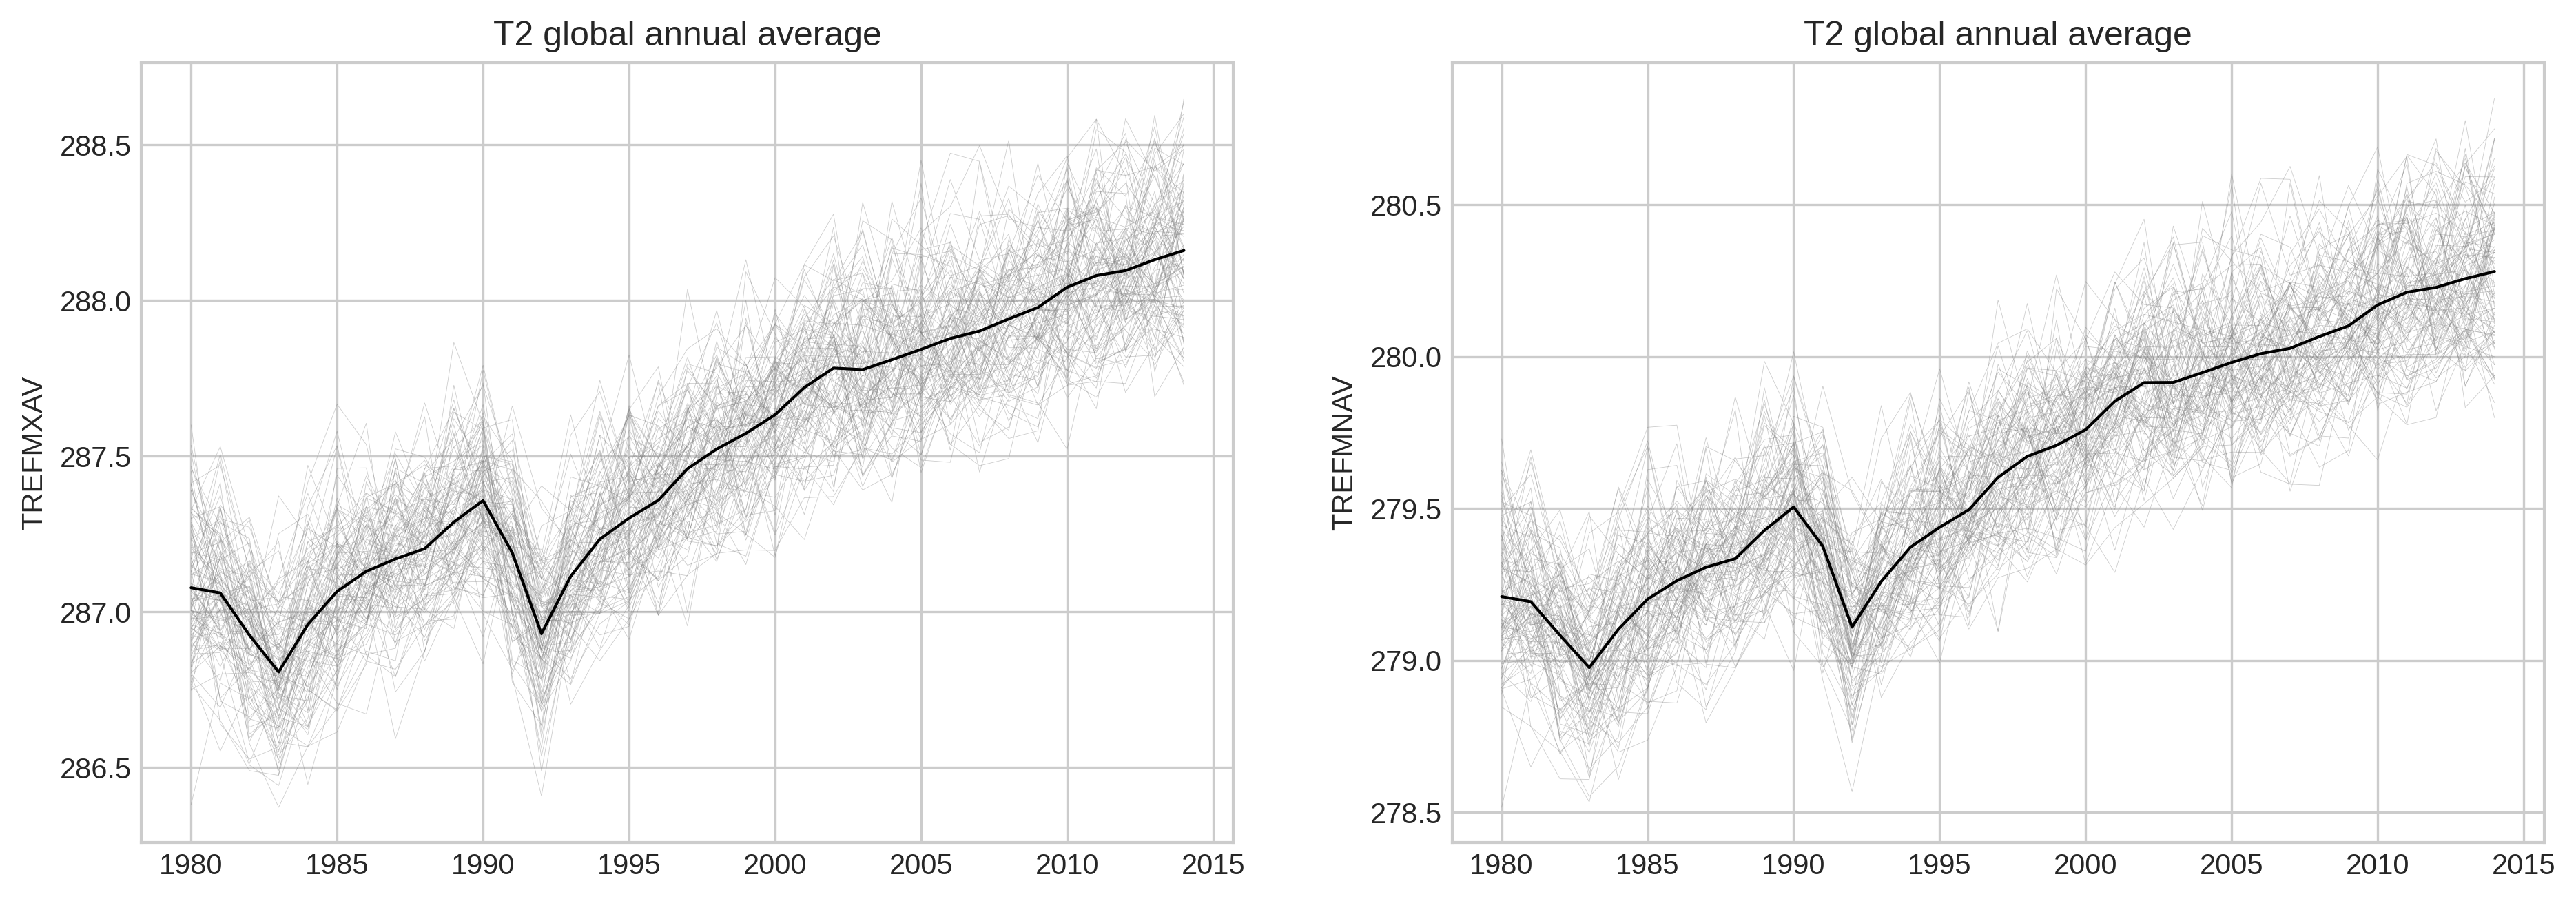

In [74]:
# for better resolution, dpi=300, default dpi = 72
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

for nv in range(n_var):
    for nm in range(n_mem):
        axs[nv].plot(range(year_s, 2015), t2_annual_3d[nv, nm, :], 'grey', linewidth=0.2, alpha=.4)
     
    axs[nv].set_ylabel(var_1d[nv])  
    axs[nv].set_title('T2 global annual average')    

    axs[nv].plot(range(year_s, 2015),  np.mean(t2_annual_3d[nv, :, :], axis=0), 'black', linewidth=1, alpha=1);

(2, 100, 35)


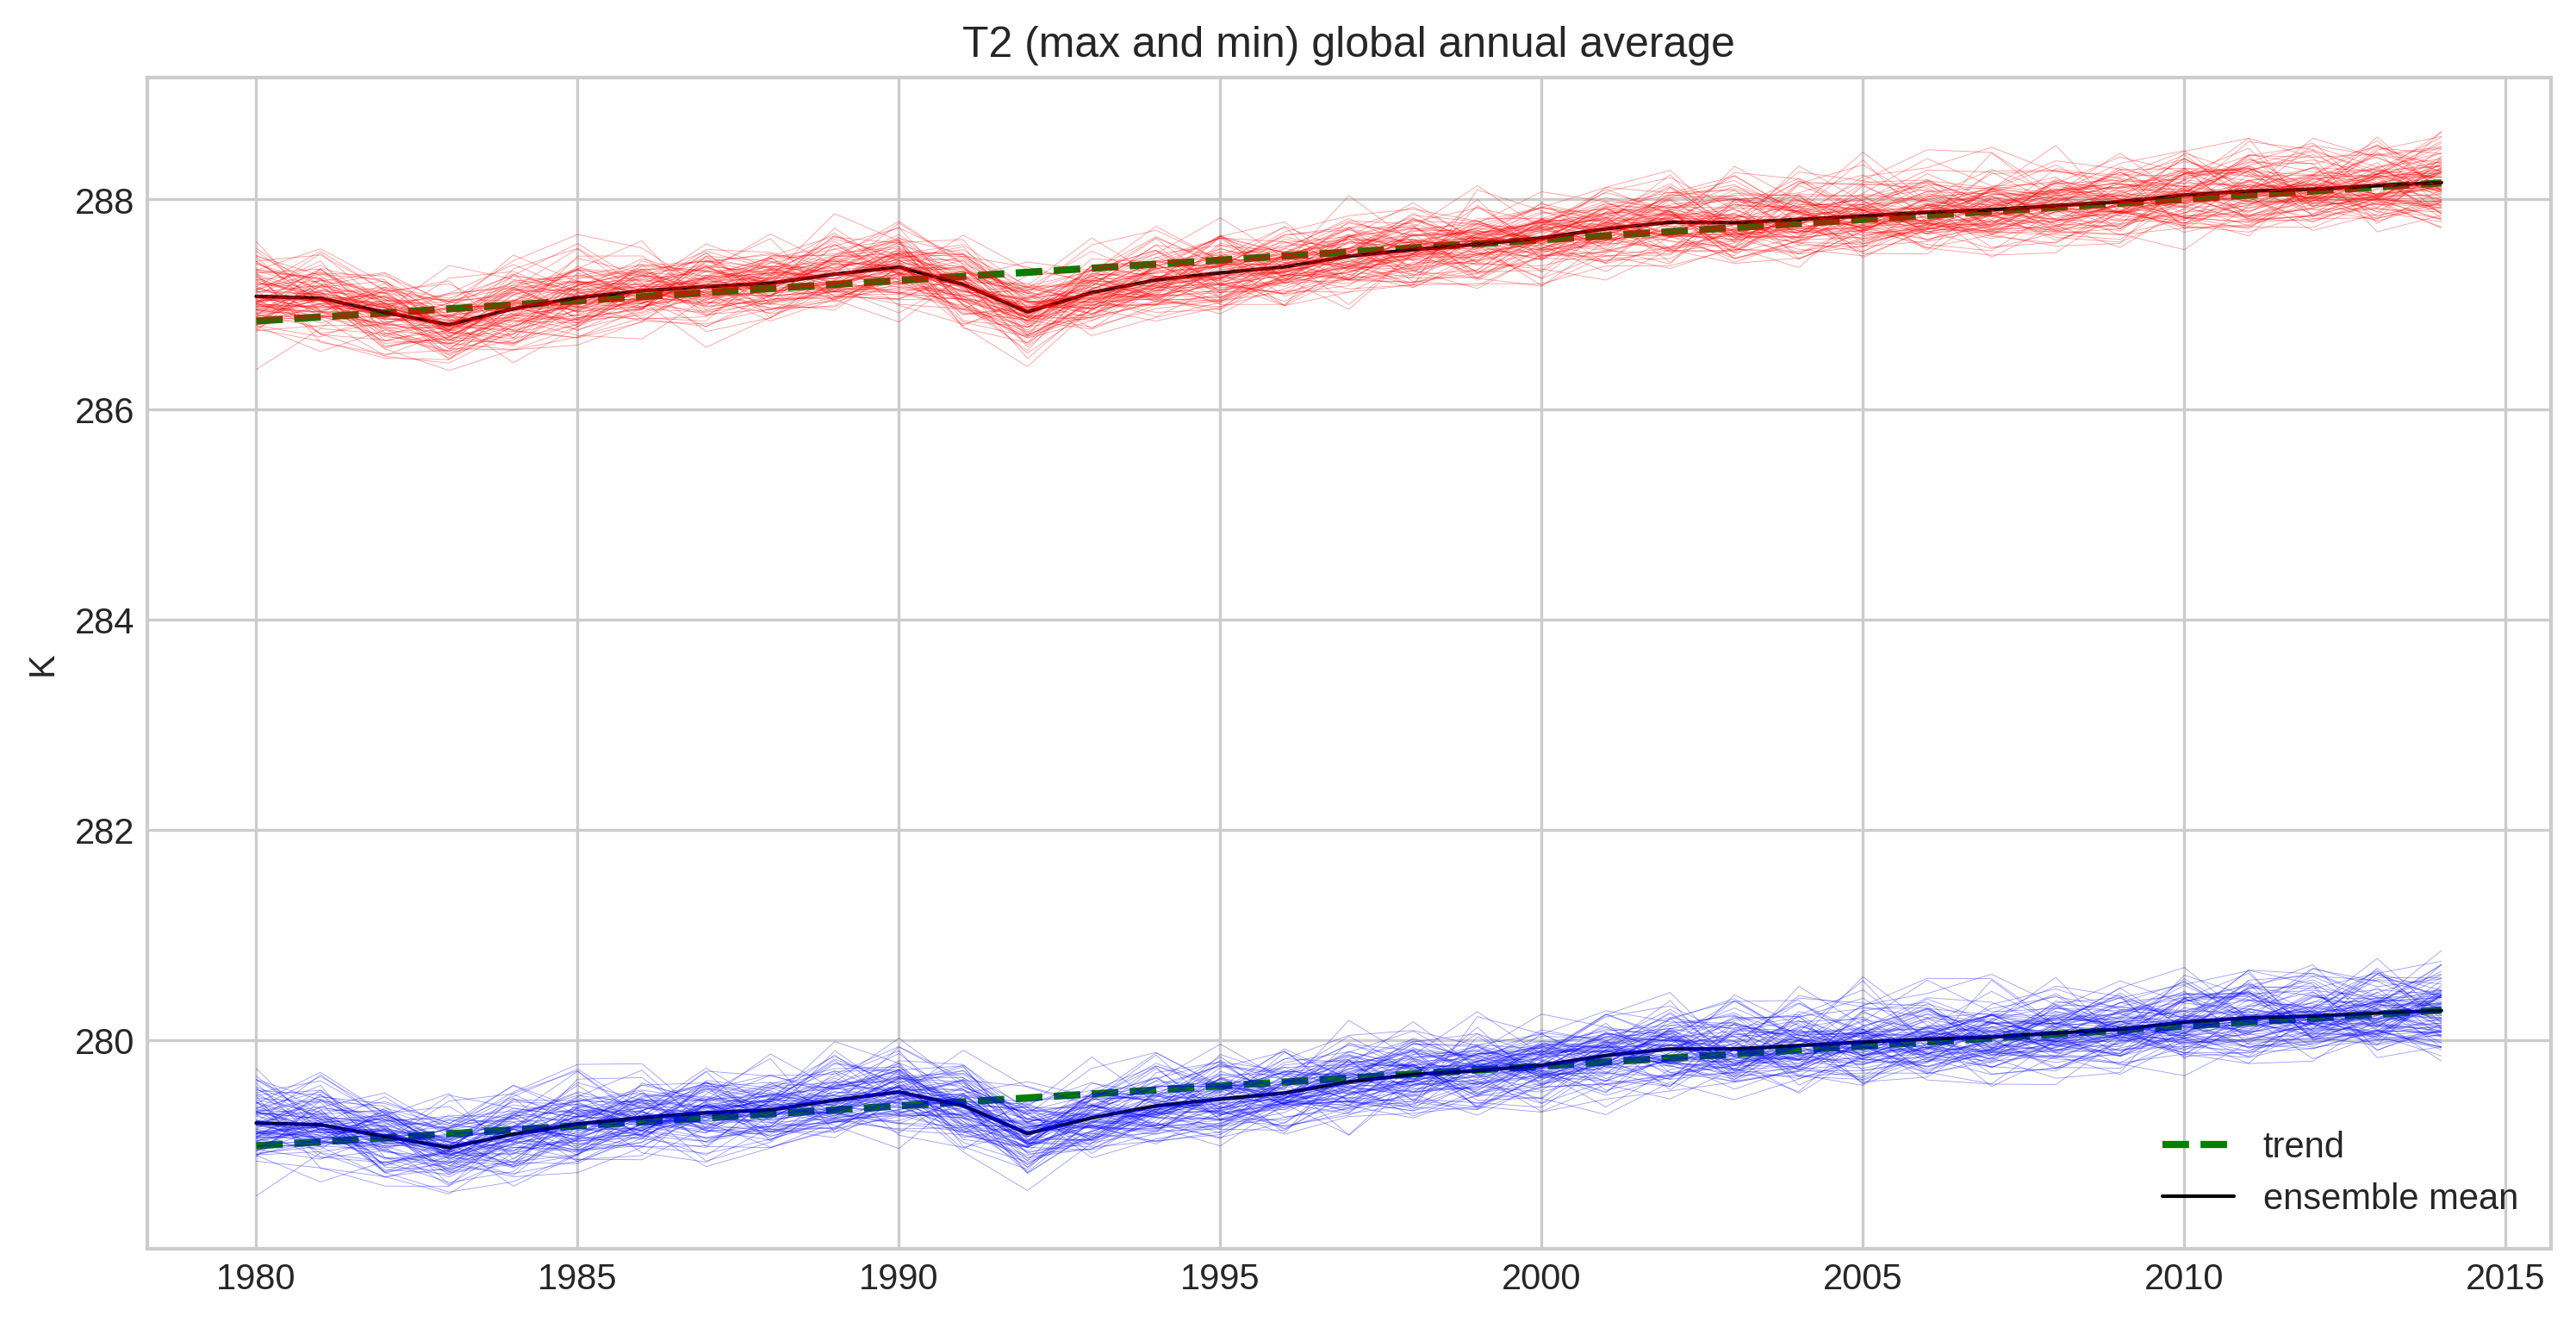

In [77]:
plt.figure(figsize=(12, 6), dpi=300)
t2_4d = t2_3d.reshape((n_var, n_mem, n_year, 12))
t2_annual_3d = np.mean(t2_4d, axis=3)
print(t2_annual_3d.shape)

#plt.plot(range(year_s, 2101),  data2_3d[:, ni, nj], 'green', linewidth=0.5, alpha=1)
for nv in range(n_var):
    t2_mean = np.mean(t2_annual_3d[nv, :, :], axis=0)
    # Calculate the Trendline
    z = np.polyfit(range(year_s, 2015), t2_mean, 1)
    p = np.poly1d(z)
    
    x = range(year_s, 2015)
    # Display the Trendline
    plt.plot(range(year_s, 2015), p(x), 'green', linewidth=2, alpha=1, linestyle='dashed')
    
    plt.plot(range(year_s, 2015), t2_mean, 'black', linewidth=1, alpha=1)
    for nm in range(n_mem):
        if nv == 0:
            plt.plot(range(year_s, 2015),  t2_annual_3d[nv, nm, :], 'r', linewidth=.2, alpha=0.4)
        else:
            plt.plot(range(year_s, 2015),  t2_annual_3d[nv, nm, :], 'b', linewidth=.2, alpha=0.4)

# Function add a legend  
plt.legend(["trend", "ensemble mean"], loc ="lower right")
plt.ylabel('K')
plt.title('T2 (max and min) global annual average');  

#### SSP370

In [ ]:
## SSP370
year_s = 2015
year_e = 2095

In [3]:
flnm = '/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.201501-202412.nc'
with xr.open_dataset(flnm) as ds:
    air = ds[var_1d[0]]
    ## For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
    weights = np.cos(np.deg2rad(air.lat))
    weights.name = "weights"
    
    # weighted mean
    air_weighted = air.weighted(weights)
    
    weighted_mean = air_weighted.mean(("lon", "lat"))
    #print(weighted_mean)
     

In [4]:
cmd_ls = 'ls -1 ' + dir_t2 + var_1d[0] + '/b.e21.BSSP370cmip6.f09_g17.*' + 'h0.TREFMXAV.201501*.nc '

# store os.system() output in a variable 
flnm_str = os.popen(cmd_ls).read()

# convert string to list and through out last item which is empty
flnm_li = list(flnm_str.split("\n"))[:-1]
n_mem = len(flnm_li)
print(n_mem, 'members') 

50 members


In [6]:
## the last one is 209501-210012 6 years
n_month = (year_e - year_s)*12 + 72
print(n_month, ' months in dataset')

n_year = int(n_month/12)

t2_3d = np.zeros((n_var, n_mem, n_month))

n_month_dec = 120

nv = 0
for var_s in var_1d:
    for year in range(year_s, year_e+1, 10):
        # the start index of each file
        ct_st = int((year-year_s)*0.1*n_month_dec)
        if year == year_e:
            ct_e = ct_st + 72
        else:
            ct_e = ct_st + n_month_dec
            
        cmd_ls = 'ls -1 ' + dir_t2 + var_1d[nv] + '/b.e21.BSSP370cmip6.f09_g17.*' + 'h0.'+var_1d[nv]+'.' + str(year)+ '01*.nc '
        # store os.system() output in a variable 
        flnm_str = os.popen(cmd_ls).read()

        # convert string to list and through out last item which is empty
        flnm_li = list(flnm_str.split("\n"))[:-1]
        n_mem_t = len(flnm_li)
        print(flnm_li[0])
        
        if n_mem_t != n_mem:
            print(n_mem_t, '!=', n_mem)
        else:
            for nm in range(n_mem):
                flnm = flnm_li[nm]
                 
                with xr.open_dataset(flnm) as ds:
                    t2_weighted = ds[var_s].weighted(weights)
                    weighted_mean = t2_weighted.mean(("lon", "lat"))
                    t2_3d[nv, nm, ct_st:ct_e] = weighted_mean
                    #print(nm, ct_st, ct_e, flnm)
    nv = nv + 1                 


1032  months in dataset
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.201501-202412.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.202501-203412.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.203501-204412.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.204501-205412.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.205501-206412.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV.206501-207412.nc
/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/TREFMXAV/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.clm2.h0.TREFMXAV

In [26]:
t2_4d = t2_3d.reshape((n_var, n_mem, n_year, 12))
t2_annual_3d = np.mean(t2_4d, axis=3)

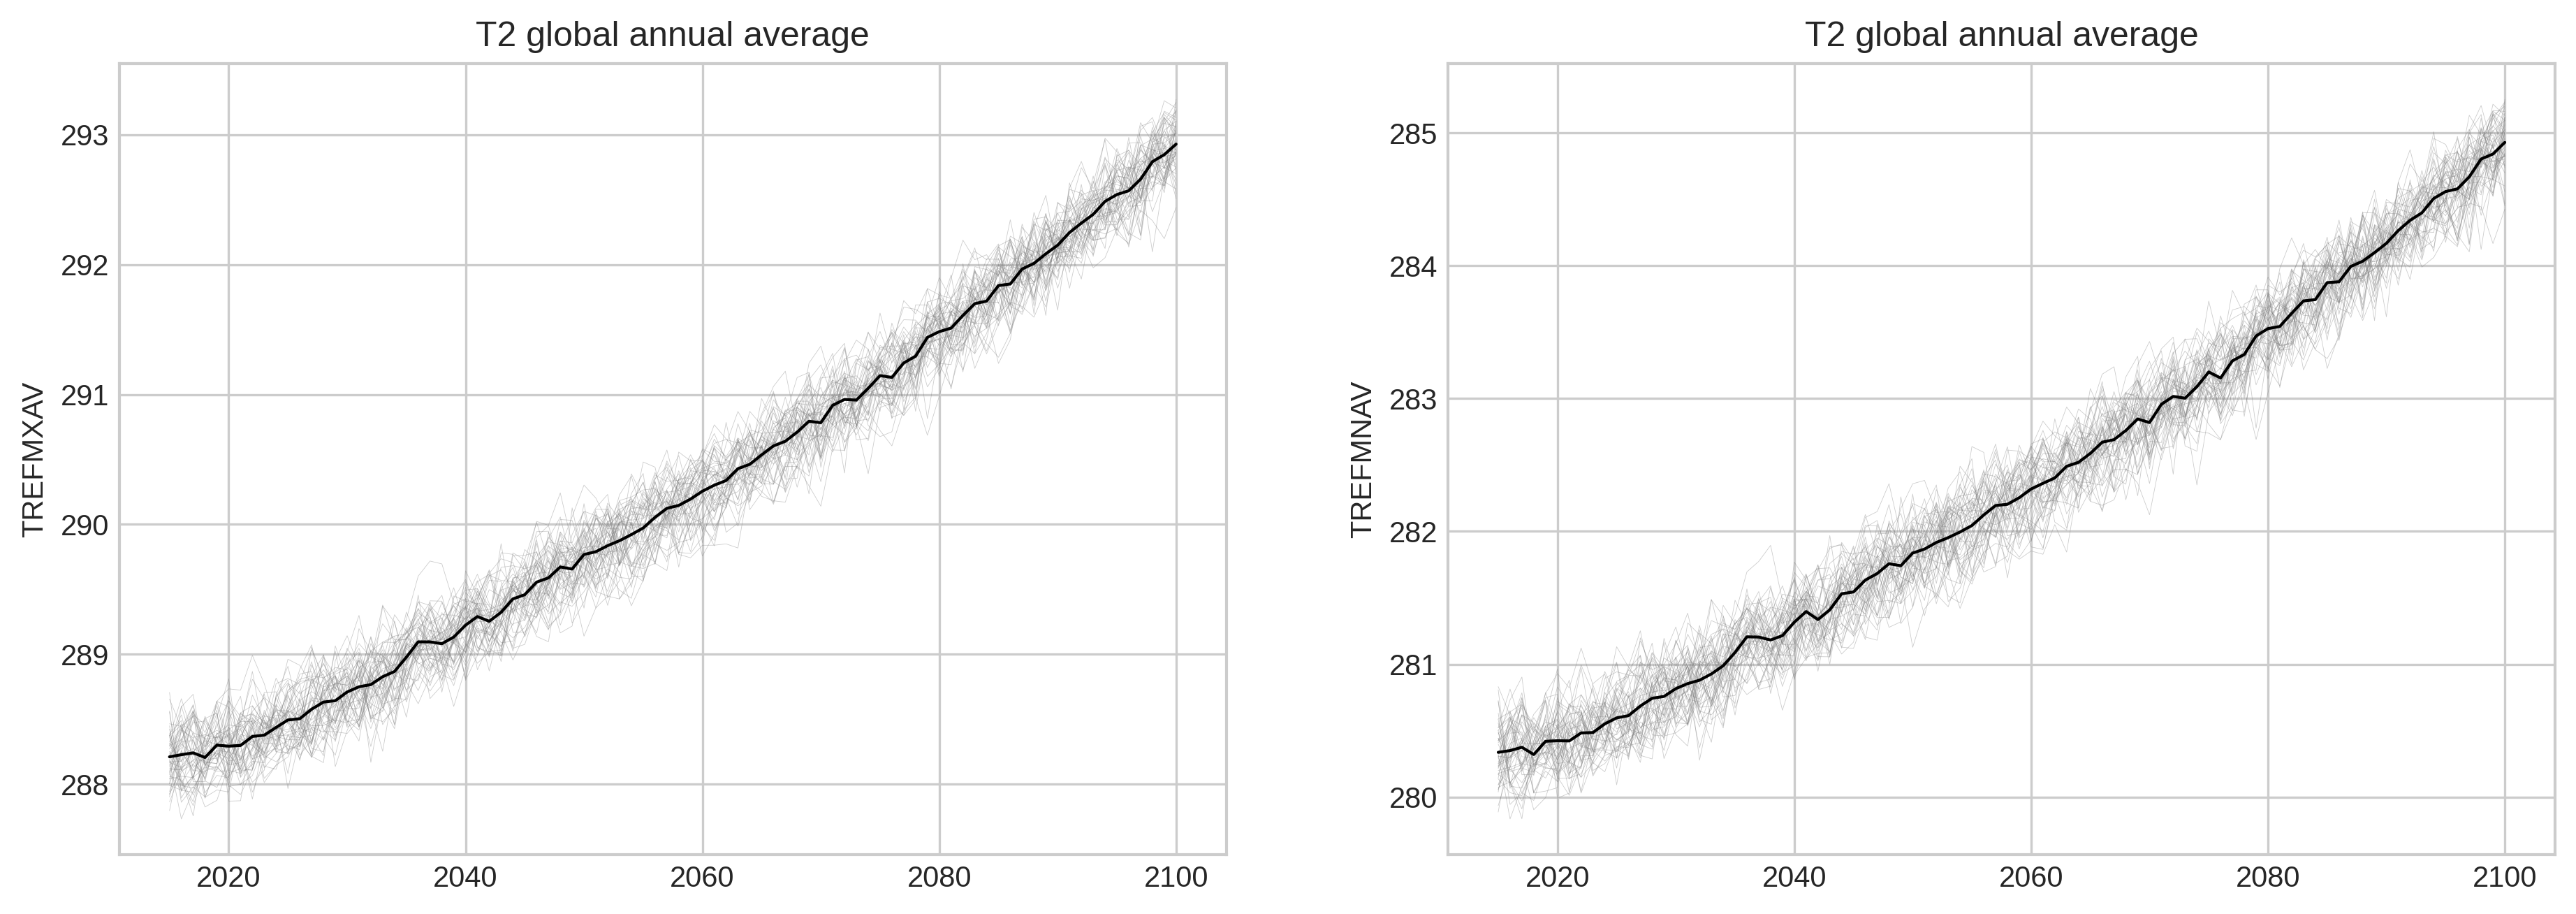

In [27]:
plt.style.use('seaborn-whitegrid')

# for better resolution, dpi=300, default dpi = 72
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

for nv in range(n_var):
    for nm in range(n_mem):
        axs[nv].plot(range(year_s, 2101), t2_annual_3d[nv, nm, :], 'grey', linewidth=0.2, alpha=.4)
     
    axs[nv].set_ylabel(var_1d[nv])  
    axs[nv].set_title('T2 global annual average')    

    axs[nv].plot(range(year_s, 2101),  np.mean(t2_annual_3d[nv, :, :], axis=0), 'black', linewidth=1, alpha=1);

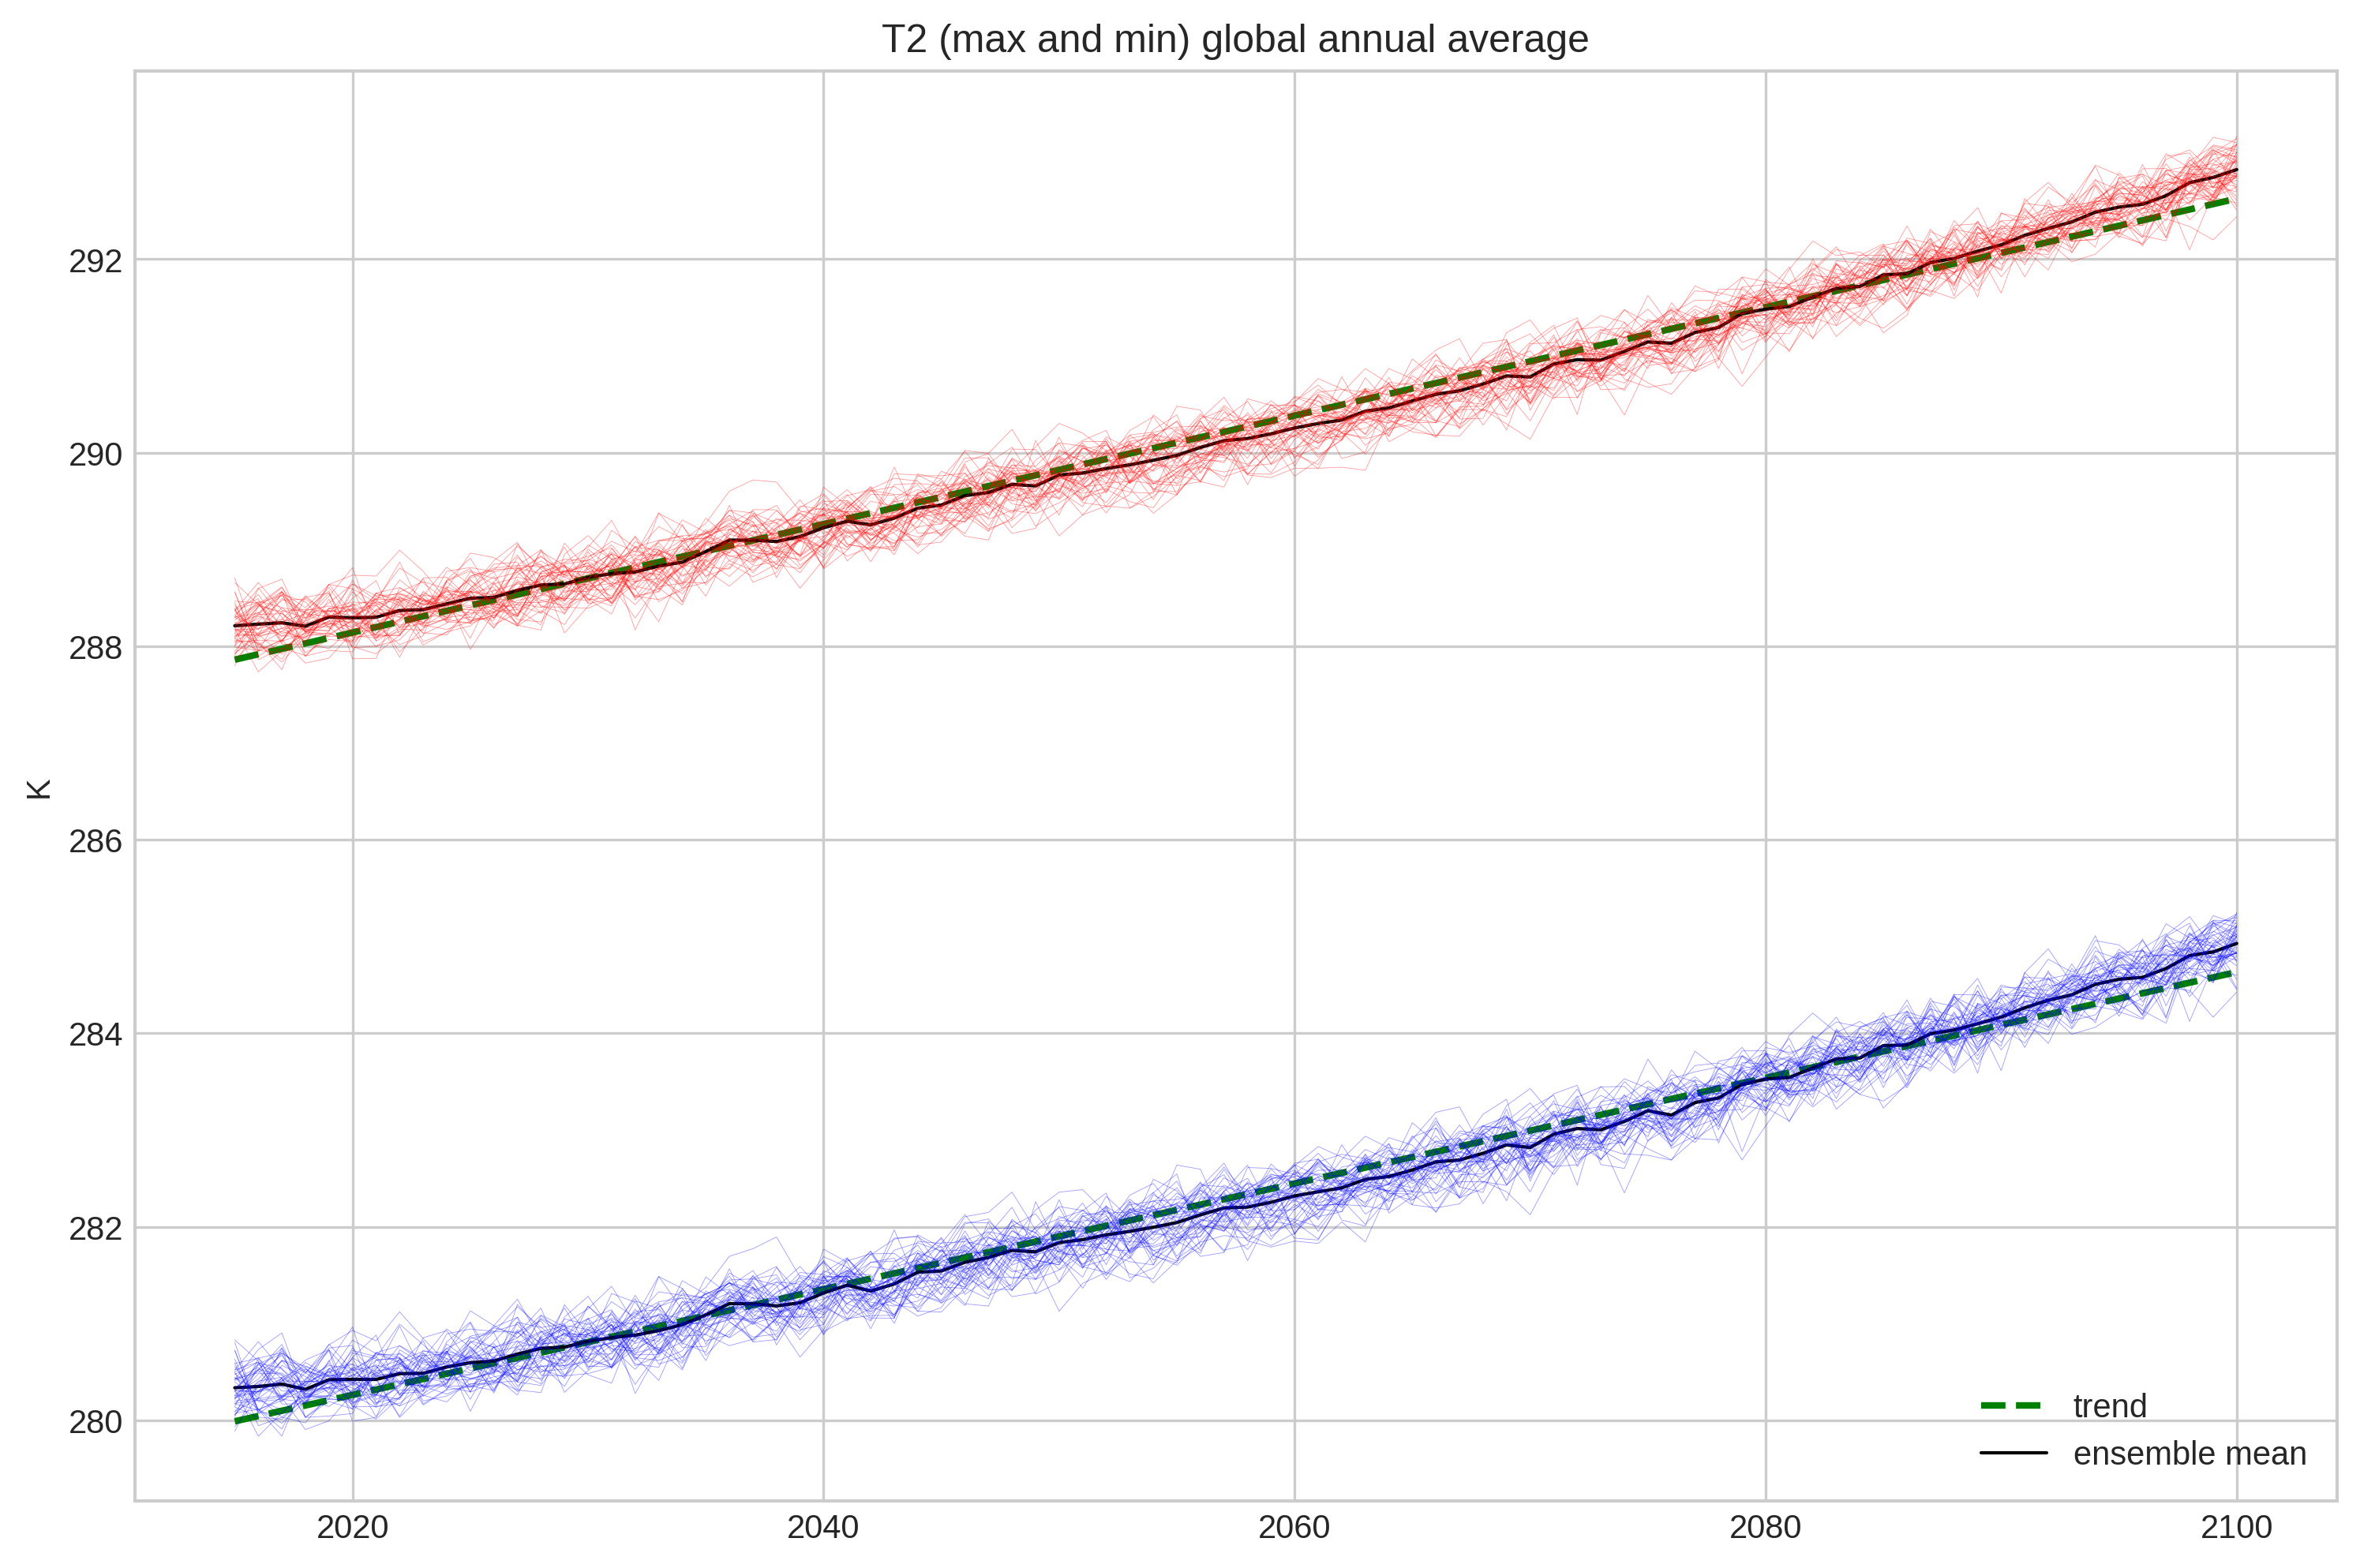

In [53]:
plt.figure(figsize=(12, 8), dpi=300)
#plt.plot(range(year_s, 2101),  data2_3d[:, ni, nj], 'green', linewidth=0.5, alpha=1)
for nv in range(n_var):
    t2_mean = np.mean(t2_annual_3d[nv, :, :], axis=0)
    # Calculate the Trendline
    z = np.polyfit(range(year_s, 2101), t2_mean, 1)
    p = np.poly1d(z)
 
    x = range(year_s, 2101)
    # Display the Trendline
    plt.plot(range(year_s, 2101), p(x), 'green', linewidth=2, alpha=1, linestyle='dashed')
    
    plt.plot(range(year_s, 2101), t2_mean, 'black', linewidth=1, alpha=1)
    for nm in range(n_mem):
        if nv == 0:
            plt.plot(range(year_s, 2101),  t2_annual_3d[nv, nm, :], 'r', linewidth=.2, alpha=0.4)
        else:
            plt.plot(range(year_s, 2101),  t2_annual_3d[nv, nm, :], 'b', linewidth=.2, alpha=0.4)

# Function add a legend  
plt.legend(["trend", "ensemble mean"], loc ="lower right")
plt.ylabel('K')
plt.title('T2 (max and min) global annual average');  